# Comparing anomaly detection algorithms for outlier detection on 3D toy datasets
---

## Brief overview

This example is an extension of an anomaly detection comparison from [``sckit-learn 2.7.1``](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py). These experiment applied six algorithms on different 3D toy dataset. Four algorithms are in sklearn, which are [``sklearn.covariance.EllipticEnvelope``](https://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html#sklearn.covariance.EllipticEnvelope), [`sklearn.svm.OneClassSVM`](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM), [`sklearn.ensemble.IsolationForest`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html#sklearn.ensemble.IsolationForest), and [`sklearn.neighbors.LocalOutlierFactor`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html#sklearn.neighbors.LocalOutlierFactor). The outlier detecting performance is measure by accuracy from [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score) and AUC score from [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html).

## Import packages
There are three main groups of package:
1. Graphing and calculation packages
2. Algorithm package
3. Performance measurement package


In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import time
import matplotlib

from sklearn import svm
from sklearn.datasets import make_moons, make_blobs
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Data simulation 

Here are the dafault parameters of the data set, which can be change according to the user:

  * ``d_noise = 10`` - the number of dimensional noise (uniform noise)
  * ``n_samples = 500`` - the number of sample
  * ``outlliers_fraction = 0.15`` - ratio of outliers to all sample (uniform distribution)
  
The data has three information dimension, which is followed figure 1 in the paper:
    
  * Madhyastha, Meghana, et al. "Geodesic Learning via Unsupervised Decision Forests." arXiv preprint arXiv:1907.02844 (2019).

There are five dataset:
  
  1. Linear line
      - Each point $x$ is parameterized by $p = (0.4t, 0.6t, t)$, with $t \in (-1, 1)$ where $t$ is sampled from a grid with equal spacing. Each point has noise, std =$0.06$ in each axis.
  2. Spiral helix
      - Each point $x$ is parameterized by $p = (t \cos(t), t\sin(t), t)$, with $t \in (2 \pi, 9 \pi)$ on an equally spaced grid. Each point has noise, std =$0.06$ in each axis.
  3. Sphere shell
      - Each point $x$ is parameterized by $p = (r \cos(u) \sin(v), r \sin(u) \sin(v), r \cos(v))$, with $u \in (0, 2\pi), v \in (0, \pi)$ and $r = 9$ where $u, v$ are sampled form a grid with equal spacing. Here is a [link](https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere) for how to generate a sphere.
  4. Three aligned gaussian mixture
      - Each point $x$ is drawn from a mixture of Gaussian distributions: $P = \sum_{j=1}^3 \hat{w}_j \mathcal{N}(\mu_j,\Sigma),$ with $(\pi_1,\pi_2,\pi_3) = (0.2,0.2,0.2)(\hat{\mu}_1,\hat{\mu}_2,\hat{\mu}_3) = \left( \ \begin{bmatrix} -0.7 \\-0.7\\-0.7 \end{bmatrix},  \begin{bmatrix} 0 \\0\\0 \end{bmatrix} , \begin{bmatrix} 0.7 \\0.7\\0.7 \end{bmatrix} \  \right)$ and $\Sigma=\mathbb{I}$ is the identity matrix.
  5. Three misaligned gaussian mixture
      - Each point $x$ is drawn from a mixture of Gaussian distributions: $P = \sum_{j=1}^3 \hat{w}_j \mathcal{N}(\mu_j,\Sigma),$ with $(\pi_1,\pi_2,\pi_3) = (0.2,0.2,0.2)(\hat{\mu}_1,\hat{\mu}_2,\hat{\mu}_3) = \left( \ \begin{bmatrix} -0.7 \\-0.7\\-0.7 \end{bmatrix},  \begin{bmatrix} 0.7 \\0.7\\-0.7 \end{bmatrix} , \begin{bmatrix} -0.7 \\0.7\\0.7 \end{bmatrix} \ \right)$ and $\Sigma=\mathbb{I}$ is the identity matrix.

In [2]:
# Data parameter
d_noise = 10  # number of uniform noise dimension
n_samples = 500
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
sd = 0.06

# Define datasets
## 1: Linear
t_lin = np.transpose(np.linspace(-1, 1, n_inliers))
X_lin = np.c_[
    0.4 * t_lin + sd * np.random.randn(n_inliers),
    0.6 * t_lin + sd * np.random.randn(n_inliers),
    t_lin + sd * np.random.randn(n_inliers),
]
## 2: Helix
t_hex = np.transpose(np.linspace(2 * np.pi, 9 * np.pi, n_inliers))
xline = t_hex * np.cos(t_hex)  # before rescale
xline = xline / (max(xline) - min(xline)) * 2 + sd * np.random.randn(n_inliers)
yline = t_hex * np.sin(t_hex)  # before rescale
yline = yline / (max(yline) - min(yline)) * 2 + sd * np.random.randn(n_inliers)
zline = (t_hex - (max(t_hex) + min(t_hex)) / 2) / (
    max(t_hex) - min(t_hex)
) * 2 + sd * np.random.randn(n_inliers)
X_hex = np.c_[xline, yline, zline]
## 3: Sphere, equally distribution
def fibonacci_sphere(samples=1, randomize=True):
    rnd = 1.0
    if randomize:
        rnd = np.random.random() * samples
    points = []
    offset = 2.0 / samples
    increment = np.pi * (3.0 - np.sqrt(5.0))
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2)
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x, y, z])
    return points


X_sph = np.array(fibonacci_sphere(samples=n_inliers))
## 4: Gaussian Mixture
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=3)
X_gau = make_blobs(
    centers=[[-0.7, -0.7, -0.7], [0, 0, 0], [0.7, 0.7, 0.7]],
    cluster_std=[0.2, 0.2, 0.2],
    **blobs_params
)[0]
## 5: Misaligned Gaussian Mixture
blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=3)
X_misaligned = make_blobs(
    centers=[[-0.7, -0.7, -0.7], [0.7, 0.7, -0.7], [-0.7, 0.7, 0.7]],
    cluster_std=[0.2, 0.2, 0.2],
    **blobs_params
)[0]
## 6: Whole dataset
datasets3D = [X_lin, X_hex, X_sph, X_gau, X_misaligned]

# define to data label: y_true
y_true = np.concatenate([np.ones(n_inliers), -np.ones(n_outliers)], axis=0)
# label 1 as inliers, -1 as outliers

## Define algorithms
The linkes of algorithms are listed in the __Overview__ section.

In [3]:
# define algorithm to be compared
anomaly_algorithms = [
    ("Robust covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("One-Class SVM", svm.OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.1)),
    (
        "Isolation Forest (IF)",
        IsolationForest(
            n_estimators=500,
            behaviour="new",
            contamination=outliers_fraction,
            random_state=42,
        ),
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(
            n_neighbors=35, contamination=outliers_fraction, novelty=True
        ),
    ),
]

## Generate 3D plot
Even though the data `X` has `3+d_noise` dimensions, we represent only the three information dimension. We add dimensional noise into the algorithm in this part.

## Performance measurement 
Each algorithm will predict the outliers and inliers using `algorithm.fit(X).predict(X)`. There are two main performance measurement in this example.
  * [`sklearn.metrics.accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score): measure the match between `y_true` and `y_predict`.
  * [`sklearn.metrics.roc_auc_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html): measure the area under receiver operating characteristic (ROC) curve.
      * [`sklearn.metrics.roc_curve`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html): show the shape of ROC curve and the thresholds. the data on the left of the thresholds are inliers and on the right are outliers.


d_noise =  10


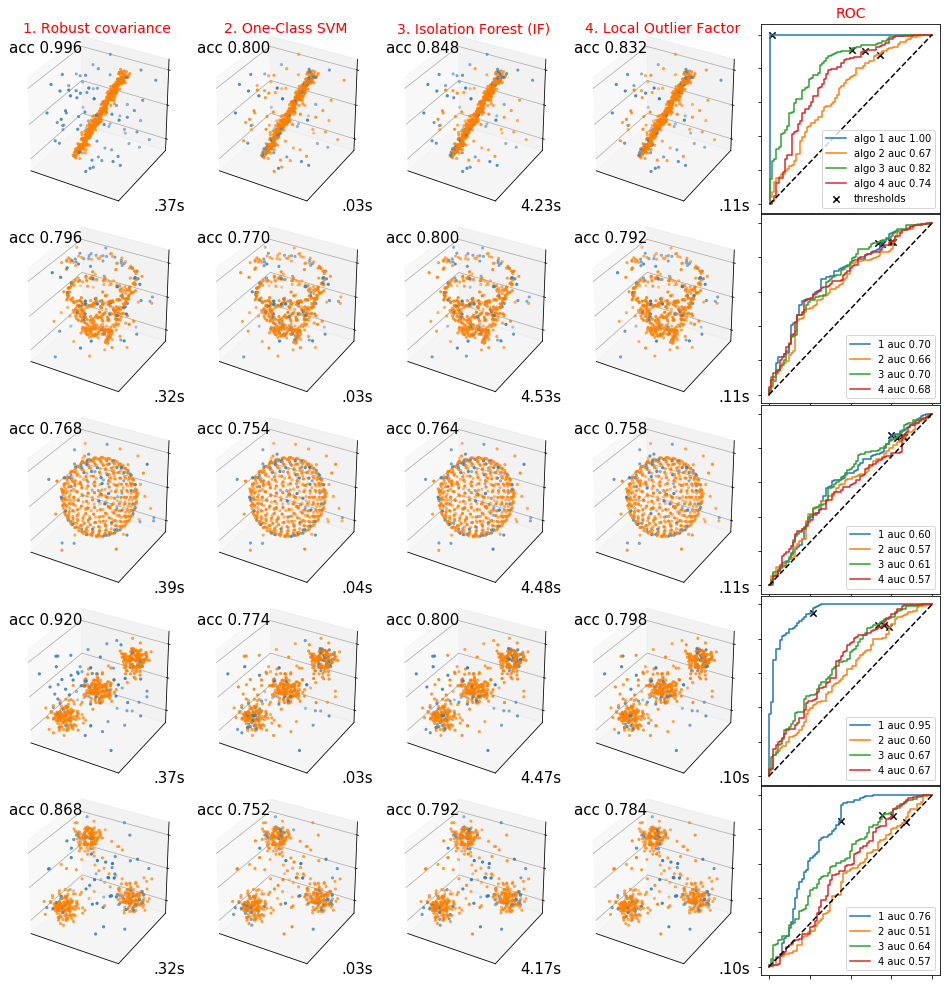

In [4]:
# Plot
plt.figure(figsize=((len(anomaly_algorithms) + 1) * 2.5 + 1, len(datasets3D) * 2.5 + 1))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.98, wspace=0.05, hspace=0.01
)
plot_num = 1
rng = np.random.RandomState(42)
for i_dataset3D, X in enumerate(datasets3D):
    X = np.concatenate(
        [X, rng.uniform(low=-1.2, high=1.2, size=(n_outliers, 3))], axis=0
    )
    # add uniform dimensional noise
    X_noise = rng.uniform(low=-1.2, high=1.2, size=(n_samples, d_noise))
    X = np.append(X, X_noise, axis=1)

    # list of AUC and ROC
    list_auc = []
    list_fpr = []
    list_tpr = []
    list_thresh = []

    algo_index = 0
    for name, algorithm in anomaly_algorithms:
        t0 = time.time()
        algorithm.fit(X)

        # fit the data and tag outliers
        y_pred = algorithm.fit(X).predict(X)

        # outlier detection performance
        acc = accuracy_score(y_true, y_pred)
        probas_ = algorithm.fit(X).decision_function(X)
        auc = roc_auc_score(y_true, probas_)
        fpr, tpr, thresholds = roc_curve(y_true, probas_)
        thresh_index = np.where(abs(thresholds) == min(abs(thresholds)))[0][0]

        # store the measurement for the plot
        list_auc.append(auc)
        list_fpr.append(fpr)
        list_tpr.append(tpr)
        list_thresh.append(thresh_index)

        t1 = time.time()

        # add data plot
        ax = plt.subplot(
            len(datasets3D), len(anomaly_algorithms) + 1, plot_num, projection="3d"
        )
        ax.axis("on")
        if i_dataset3D == 0:
            plt.title(
                str(algo_index + 1) + ". " + name, size=14, color="red"
            )  # use function's name for a title
        colors = np.array(["#377eb8", "#ff7f00"])
        # color plot ('blue' = outlier, 'orange'=inlier)
        ax.scatter3D(X[:, 0], X[:, 1], X[:, 2], s=5, color=colors[((y_pred + 1) // 2)])
        ax.text2D(
            0.01,
            0.85,
            ("acc %.3f" % acc).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="left",
        )
        ax.text2D(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.zaxis.set_ticklabels([])
        algo_index += 1
        plot_num += 1
    # add ROC plot
    ax = plt.subplot(len(datasets3D), len(anomaly_algorithms) + 1, plot_num)
    if i_dataset3D == 0:
        plt.title("ROC", size=14, color="red")  # use function's name for a title
    for algo_index in range(len(anomaly_algorithms)):
        # plot ROC and threshold point
        # many if and else is to clean the legend
        if i_dataset3D == 0:
            ax.plot(
                list_fpr[algo_index],
                list_tpr[algo_index],
                label="algo "
                + str(algo_index + 1)
                + (" auc %.2f" % list_auc[algo_index]).lstrip("0"),
            )
            if algo_index == 0:
                ax.scatter(
                    list_fpr[algo_index][list_thresh[algo_index]],
                    list_tpr[algo_index][list_thresh[algo_index]],
                    s=40,
                    edgecolor="yellow",
                    marker="x",
                    color="black",
                    label="thresholds",
                )
            else:
                ax.scatter(
                    list_fpr[algo_index][list_thresh[algo_index]],
                    list_tpr[algo_index][list_thresh[algo_index]],
                    s=40,
                    edgecolor="yellow",
                    marker="x",
                    color="black",
                )
        else:
            ax.plot(
                list_fpr[algo_index],
                list_tpr[algo_index],
                label=str(algo_index + 1)
                + (" auc %.2f" % list_auc[algo_index]).lstrip("0"),
            )
            ax.scatter(
                list_fpr[algo_index][list_thresh[algo_index]],
                list_tpr[algo_index][list_thresh[algo_index]],
                s=40,
                edgecolor="yellow",
                marker="x",
                color="black",
            )
    ax.plot(np.array([0, 1]), np.array([0, 1]), linestyle="--", color="black")
    # show the legend
    ax.legend()
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    plot_num += 1
print("d_noise = ", str(d_noise))
plt.show()

## Result and disscussion 
``sklearn.covariance.EllipticEnvelope`` shows best result in high ``d_noise = 10``. However, since robust covariance create a ellptical envelope for inliers, we need more test on an inlier data that is not in a elliptical shape.